# Understanding and Predicting future product prices

## Sales

### Author: Harry Patterson

                          ====================================================

## Table of Contents
### Overview
- [Problem: What determines future sales of products?](#Problem)
- [Objective: Predict future sales](#Objective)

### Data Quality Check
- [Simple Inspection of Data](#Inspection)

### Data Cleaning
- [Data Cleaning](#Datacleaning)


### Exploratory Data Analysis
- [Customers](#Eda1)
- [Open/Close](#Eda2)
- [Distributions](#Dis)
- [Merging Data](#Merge)
- [Date](#Date)
- [Sales](#Visual)
- [StoreType](#Store)
- [Promo](#Promo)

### Model Selection 
- [Train Model](#FB)

***

<a id='Problem'></a>
# The Problem:

-  Sales department needs to understand what drives future sales in order to be more competitive and increase the companies' growth.  

***

<a id='Objective'></a>
# The Objective

- We will leverage AI/ML models to develop predictive models to forecast product sales in the future. 
- We will attempt to use these predictive models to forecast future daily sales based on historical data (collected data from 1115 stores)
- Try to fully understand the features we are given to increase revenue. 

***

## IMPORT LIBRARIES 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [4]:
pip install pystan==2.18.0.0

     |████████████████████████████████| 17.5 MB 3.8 MB/s eta 0:00:01
  Created wheel for pystan: filename=pystan-2.18.0.0-cp38-cp38-macosx_10_15_x86_64.whl size=30395176 sha256=c27e2d521810e86197b2e320639c056b6ae6929d2b2f0c6e3fc51e35d6382eb5
  Stored in directory: /Users/harrypatterson/Library/Caches/pip/wheels/c9/8d/a0/87147a86c11b867cb8e500fa47c9dd551624c336159f4a7b9f
Successfully built pystan
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=699828 sha256=7adde025e58dc590f814516485d7780e0457d2f83a673a99d8d4e2c65a1edf09
  Stored in directory: /Users/harrypatterson/Library/Caches/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
Note: you may need to restart the kernel to use updated packages.


In [6]:
from fbprophet import Prophet

In [7]:
# Functions to use

def creating_histplot(size, data, features):    # (size:(height,length))
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(3, 3, i+1)                  # (rows, columns)
        sns.histplot(data[features[i]], kde = True)
        
        
def crossCorrelation(data):
    corr = data.corr()
    plt.figure(figsize=(20,20))
    sns.heatmap(corr,annot=True,
          xticklabels=corr.columns.values,
          yticklabels=corr.columns.values)
    print(corr)

## The Data

### Transaction data

- Store: unique store Id
- Dayofweek: Which day of the week (1-7)
- Date: Date of transaction
- Sales: sales/day, this is the target variable (euro)
- Customers: number of customers on a given day
- Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
- Promo: describes if store is running a promo on   that day or not
- StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools


### Specific store data 

- Store: unique store Id
- StoreType: categorical variable to indicate type of store (a, b, c, d)
- Assortment: describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance (meters): distance to closest competitor store
- CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open
- Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
- Promo2Since [Year/Week]: date when the store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

***

<a id='Inspection'></a>
# Inspection of data

***

### Data that Consits of all transaction data

In [8]:
sales_transactions = pd.read_csv('Data/train.csv', low_memory=False)
sales_transactions.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
6,7,5,2015-07-31,15344,1414,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
9,10,5,2015-07-31,7185,681,1,1,0,1


In [9]:
sales_transactions.shape

(1017209, 9)

In [10]:
sales_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [11]:
sales_transactions.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [12]:
sales_transactions.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [13]:
sales_transactions.describe(include='O')

,Date,StateHoliday
count,1017209,1017209
unique,942,4
top,2015-03-17,0
freq,1115,986159


### Data that consists of the store specific information data
- Unique information about the 1115 stores

In [14]:
store_info = pd.read_csv('Data/store.csv')
store_info.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [15]:
store_info.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [16]:
store_info.shape

(1115, 10)

In [17]:
store_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [18]:
store_info.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [19]:
store_info.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [20]:
store_info.describe(include='O')

,StoreType,Assortment,PromoInterval
count,1115,1115,571
unique,4,3,3
top,a,a,"Jan,Apr,Jul,Oct"
freq,602,593,335


In [21]:
print('Number of duplicated records in training set: ', store_info.duplicated().sum())

Number of duplicated records in training set:  0


In [22]:
store_info.PromoInterval.unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [23]:
store_info.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

### Results 

- We can see that there are many missing values in the competition and promo columns. Will take a look at those. 
- Have an average sales amount of about 5774 Euros per day and also days where sales are 0 per day (We can assume that stores may be closed on those days)
- The maximum sales per day comes in at 41551 which we can some may just be the biggest store or best strategic location. 
- Overall, the data makes sense. 
***

<a id='Datacleaning'></a>
# Data Cleaning 


***

### Explore missing data in sales transactions data

<AxesSubplot:>

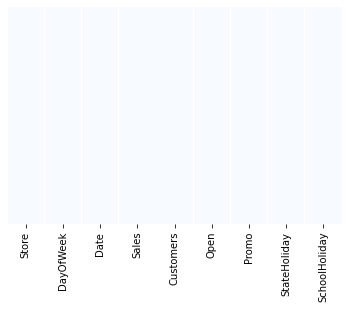

In [24]:
sns.heatmap(sales_transactions.isnull(), yticklabels=False, cbar = False, cmap='Blues')

### Explore missing data in store info data

<AxesSubplot:>

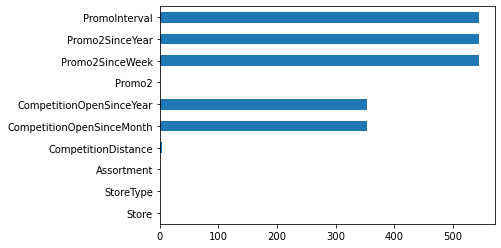

In [25]:
# barchart for missing values in each column

nullvalues = store_info.isnull().sum()
nullvalues.plot.barh()

### Look at competition distance missing values first since it is the smallest amount 

In [26]:
store_info[store_info['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


### Look at competition open since month missing values first since it is the smallest amount 

In [27]:
store_info[store_info['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


### Look at competition open since year missing values first since it is the smallest amount 

In [28]:
store_info[store_info['CompetitionOpenSinceYear'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


### Look at Promo 2 since week missing values first since it is the smallest amount 

In [29]:
store_info[store_info['Promo2SinceWeek'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


### Look at promo 2 since year missing values first since it is the smallest amount 

In [30]:
store_info[store_info['Promo2SinceYear'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


### Look at promo interval missing values first since it is the smallest amount 

In [31]:
store_info[store_info['PromoInterval'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


In [32]:
# Will look at promo2 when stores is not running a promotion to see what was happening 

store_info[store_info['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


In [33]:
# Looks like if 'promo2' is zero, 'promotion2sinceweek', 'Promo2sinceyear', and 'promointerval' information is missing
# Due to stores not running a promotion on certain days. we will set promo information to zero when stores are not running a promotion
# inplace: fill that value in memory

str_cols = ['Promo2SinceWeek','Promo2SinceYear','PromoInterval','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']

for str in str_cols:
    store_info[str].fillna(0, inplace = True)

In [34]:
# Fill in missing values for 'CompetitionDistance' with an average 

store_info['CompetitionDistance'].fillna(store_info['CompetitionDistance'].mean(), inplace = True)

In [35]:
# Checking work 

store_info.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

### Results 

- Notice that when promo2 is set to 0 then all other data regarding promos are null values becasue the store was not running any promos. 
- Change the empty values in 'promotion2sinceweek', 'Promo2sinceyear', and 'promointerval' to zero to be able to keep the data
- Since Only 3 empty values in 'CompetitionOpenSinceYear','CompetitionOpenSinceMonth'. We just put in an average. 

*** 

<a id='Eda1'></a>
# Examine Customers

***

In [36]:
sales_transactions['Customers'].max()

7388

<a id='Eda2'></a>
# Examine Open and Close

- See how many stores are open and closed
- We only care about the open days due to other features such as sales being 0. 
***

In [37]:
closed_stores = sales_transactions[sales_transactions['Open']==0]
open_stores = sales_transactions[sales_transactions['Open']==1]

In [38]:
print('Total = ', len(sales_transactions))
print('Number of closed stores = ', len(closed_stores))
print('Number of open stores = ', len(open_stores))

Total =  1017209
Number of closed stores =  172817
Number of open stores =  844392


In [39]:
# Will only keep open stores and removed closed stores 

sales_transactions = sales_transactions[sales_transactions['Open'] == 1]

In [40]:
# checking work
sales_transactions.Open.unique()

array([1])

In [41]:
# Will drop open column due to the data only containg the opened stores data now. 

sales_transactions = sales_transactions.drop(columns = ['Open'])

In [42]:
sales_transactions

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1
...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,0,a,1
1016827,733,2,2013-01-01,10765,2377,0,a,1
1016863,769,2,2013-01-01,5035,1248,0,a,1
1017042,948,2,2013-01-01,4491,1039,0,a,1


<a id='Dis'></a>
# Distributions  

- For store information and sales transactions 

***

array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'DayOfWeek'}>],
       [<AxesSubplot:title={'center':'Sales'}>,
        <AxesSubplot:title={'center':'Customers'}>],
       [<AxesSubplot:title={'center':'Promo'}>,
        <AxesSubplot:title={'center':'SchoolHoliday'}>]], dtype=object)

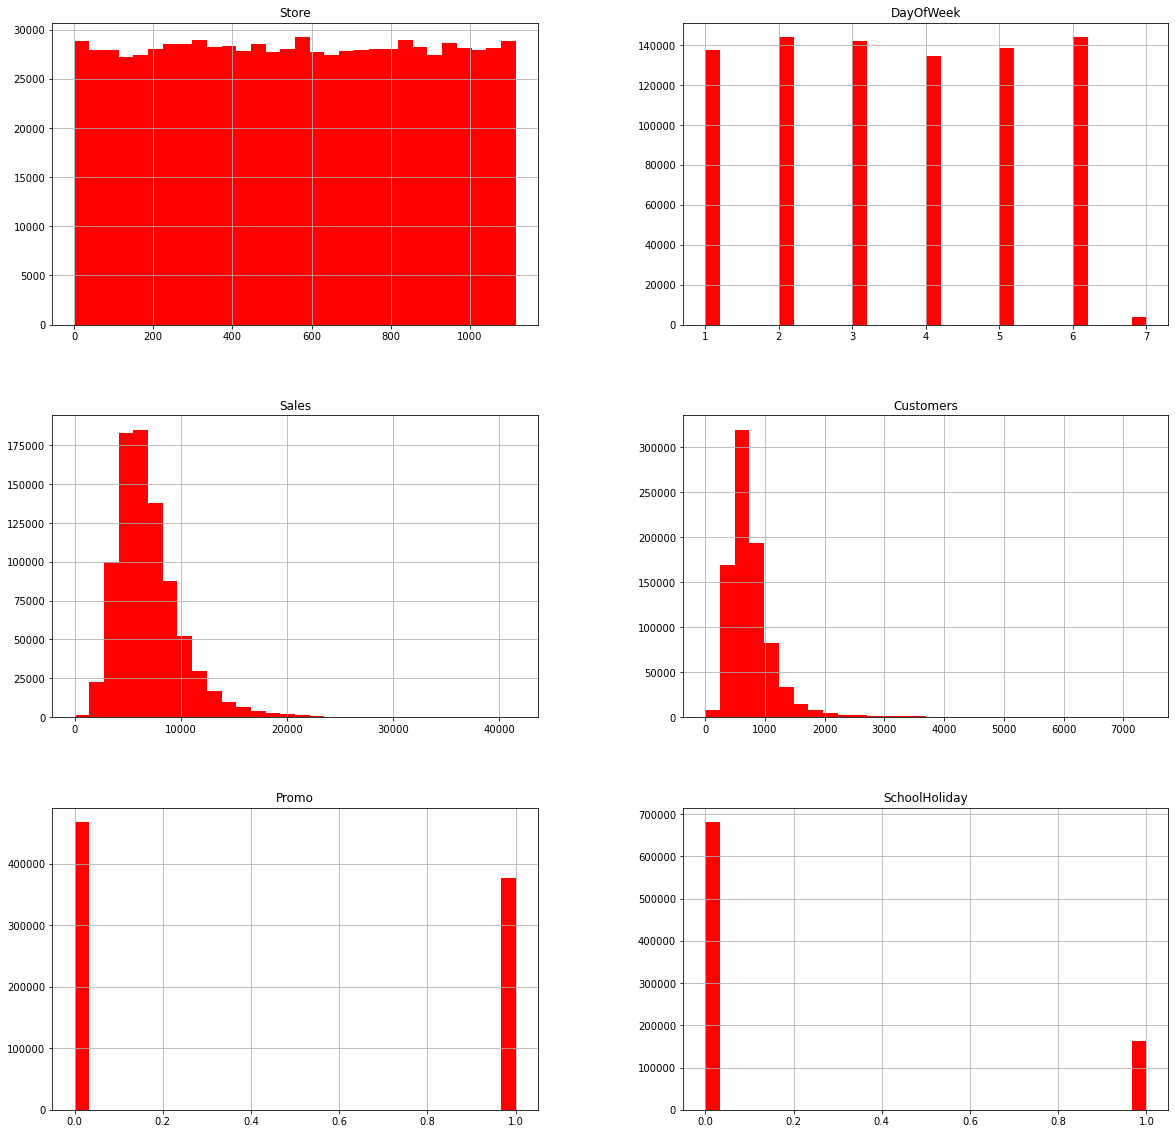

In [43]:
sales_transactions.hist(bins = 30, figsize = (20,20), color = 'r')

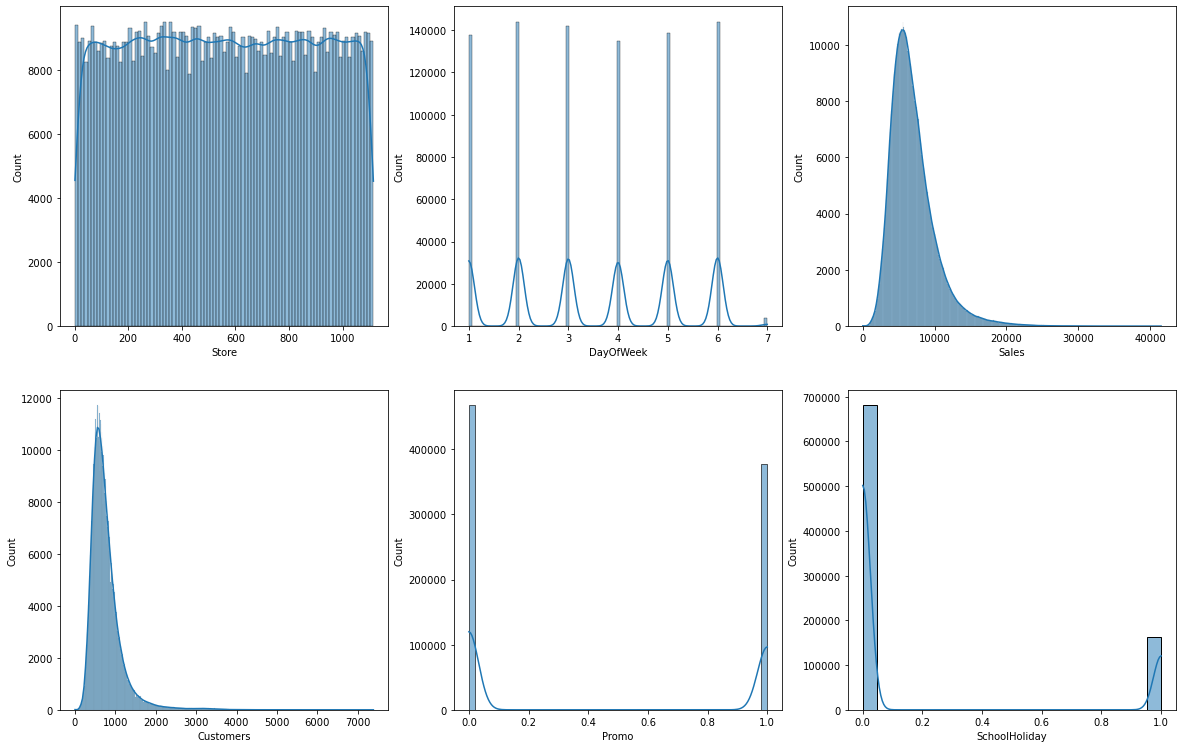

In [44]:
num_vars = sales_transactions.select_dtypes(exclude=['object']).columns

# Creating distribution plots
creating_histplot((20,20), sales_transactions, num_vars)      # (width, length )

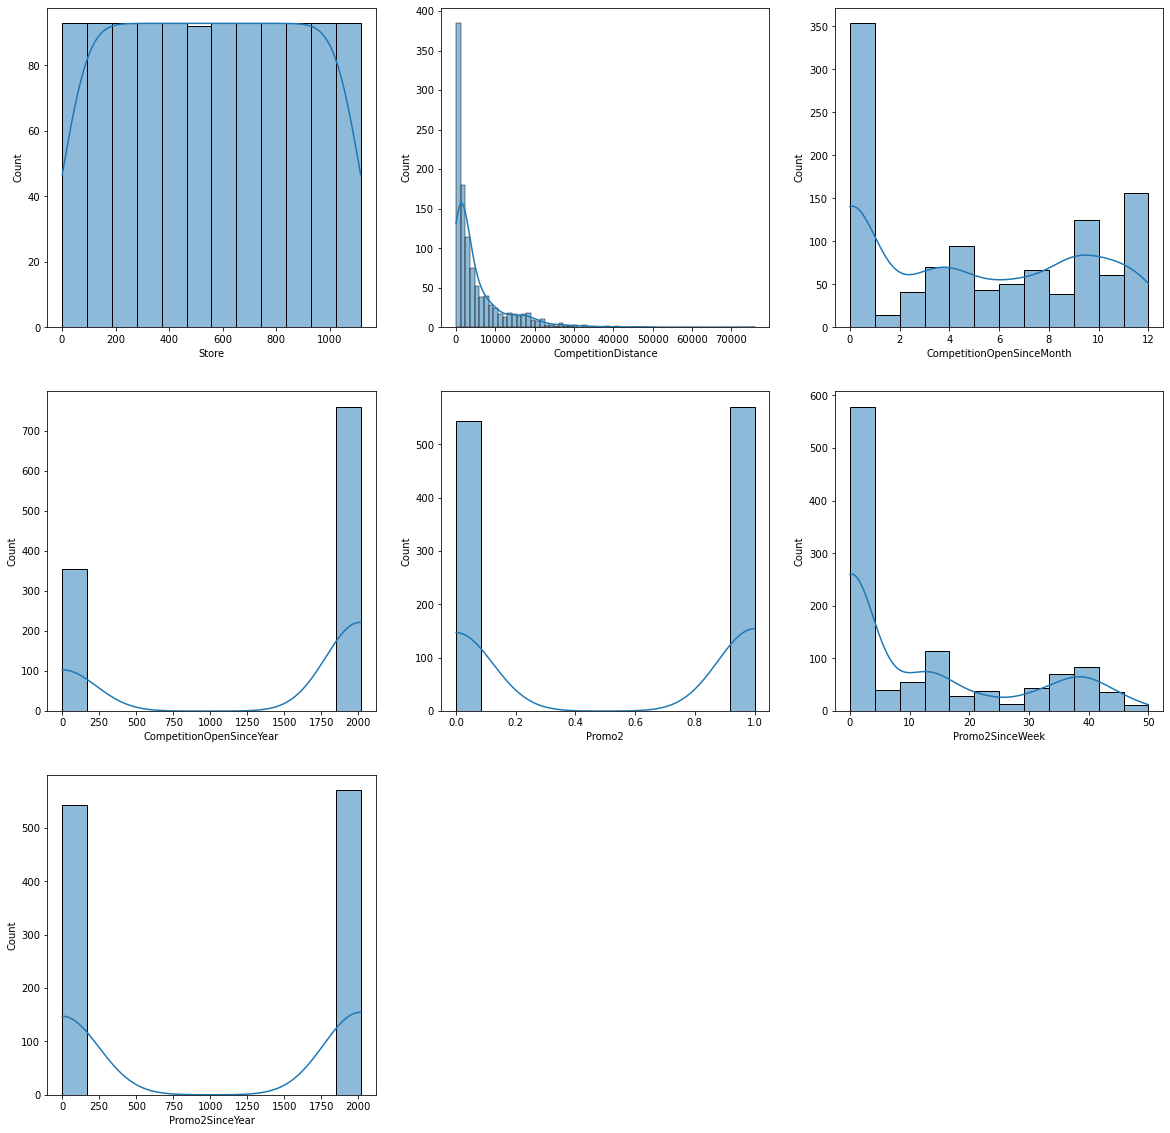

In [45]:
num_vars = store_info.select_dtypes(exclude=['object']).columns

# Creating distribution plots
creating_histplot((20,20), store_info, num_vars)      # (width, length )

### Results 

sales transaction
- Data is equally distibuted across various Days of the week.
- Data is equally distributed among all stores (no bias). 
- Stores Average about 800 customers per day.
- Stores are running promos most of the time. 
- Can see that the bulk of the data is 7000 sales per day. 

Store info
- Looks around half the stores competition distance are around 0-3000 meters away

***

<a id='Merge'></a>
# Merge Data Dataframes And Examine

- Based on Store

***

In [46]:
store_sales_merged = pd.merge(sales_transactions, store_info, how= 'inner', on = 'Store')

In [47]:
store_sales_merged

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


### Examine correlation between independent variables 

- Cross-correlation between the different features
- Do not want all features correlated with eachother 

In [48]:
# Create a correlation matrix

correlations = store_sales_merged.corr()['Sales'].sort_values()
correlations

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

<AxesSubplot:>

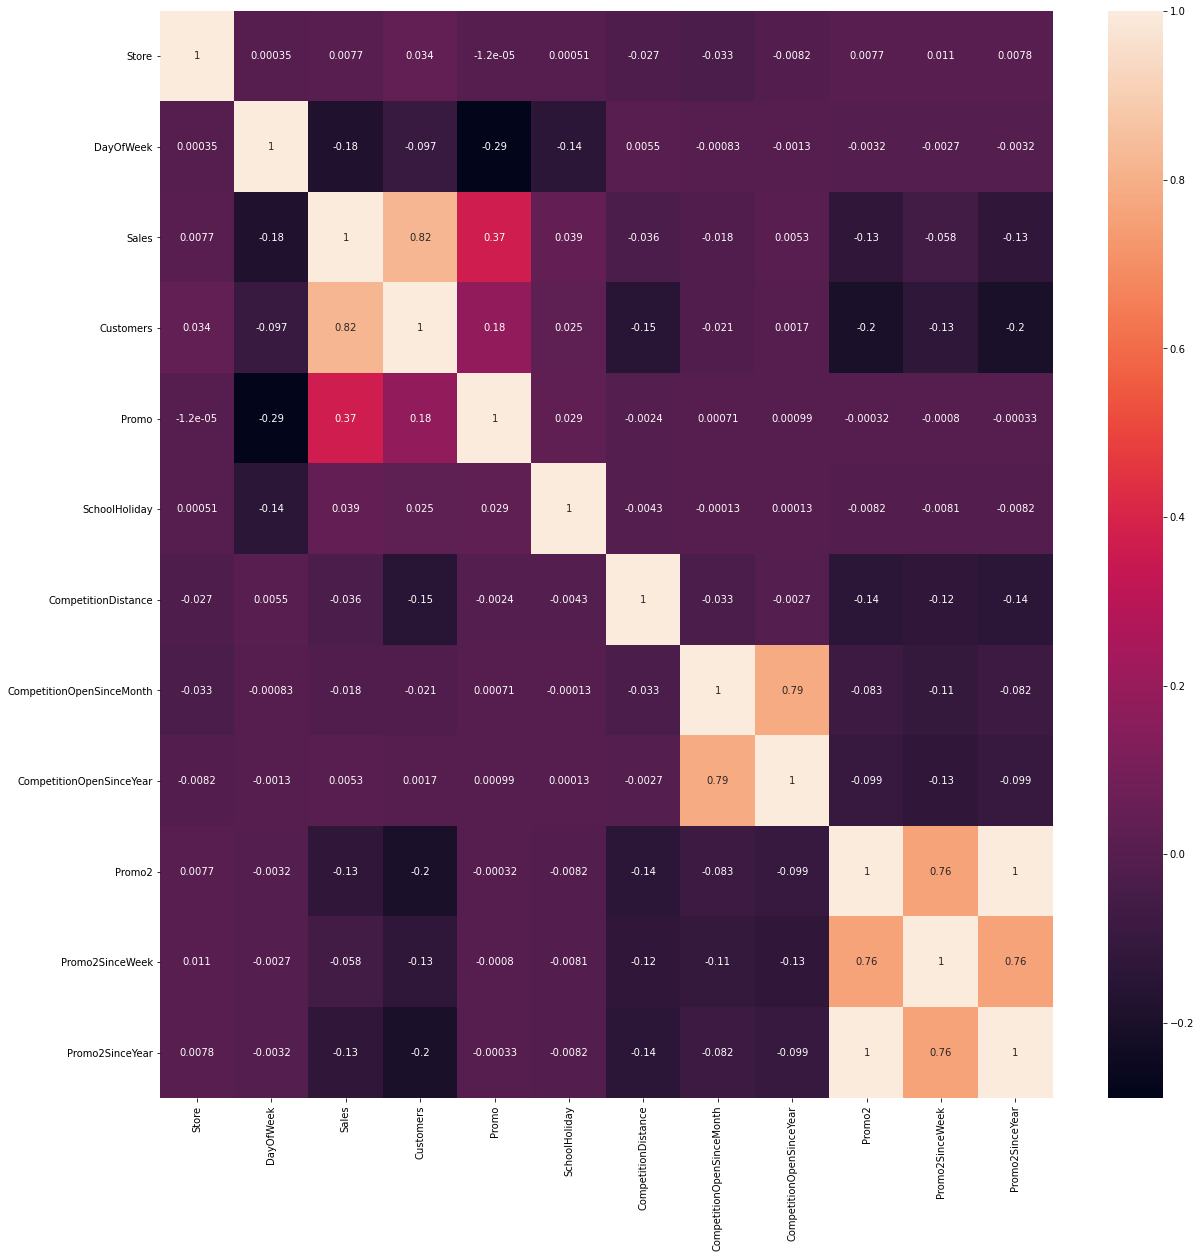

In [49]:
correlations = store_sales_merged.corr()
f, ax = plt.subplots(figsize = (20,20))
sns.heatmap(correlations, annot = True)

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
Store,1.000000,-0.027804,-0.080665,-0.024822,-0.097300,-0.080324,-0.091104,-0.163819,-0.142811,-0.099283,-0.096803,-0.099264
DayOfWeek,-0.027804,1.000000,-0.431006,-0.306637,-0.619114,-0.306294,0.023796,-0.023784,-0.030081,-0.012029,-0.023078,-0.012025
Sales,-0.080665,-0.431006,1.000000,0.965164,0.559452,0.004251,-0.151777,-0.140768,-0.112779,-0.454533,-0.391468,-0.454549
Customers,-0.024822,-0.306637,0.965164,1.000000,0.407221,0.006270,-0.214528,-0.095648,-0.066731,-0.508818,-0.446461,-0.508824
Promo,-0.097300,-0.619114,0.559452,0.407221,1.000000,0.017196,-0.076540,-0.123616,-0.118022,-0.193743,-0.177780,-0.193753
SchoolHoliday,-0.080324,-0.306294,0.004251,0.006270,0.017196,1.000000,-0.037220,-0.090320,-0.092206,-0.136377,-0.137864,-0.136382
CompetitionDistance,-0.091104,0.023796,-0.151777,-0.214528,-0.076540,-0.037220,1.000000,-0.053264,-0.023801,-0.345591,-0.348082,-0.345639
CompetitionOpenSinceMonth,-0.163819,-0.023784,-0.140768,-0.095648,-0.123616,-0.090320,-0.053264,1.000000,0.967759,-0.348457,-0.397462,-0.348392
CompetitionOpenSinceYear,-0.142811,-0.030081,-0.112779,-0.066731,-0.118022,-0.092206,-0.023801,0.967759,1.000000,-0.386336,-0.434163,-0.386273
Promo2,-0.099283,-0.012029,-0.454533,-0.508818,-0.193743,-0.136377,-0.345591,-0.348457,-0.386336,1.000000,0.960782,1.000000


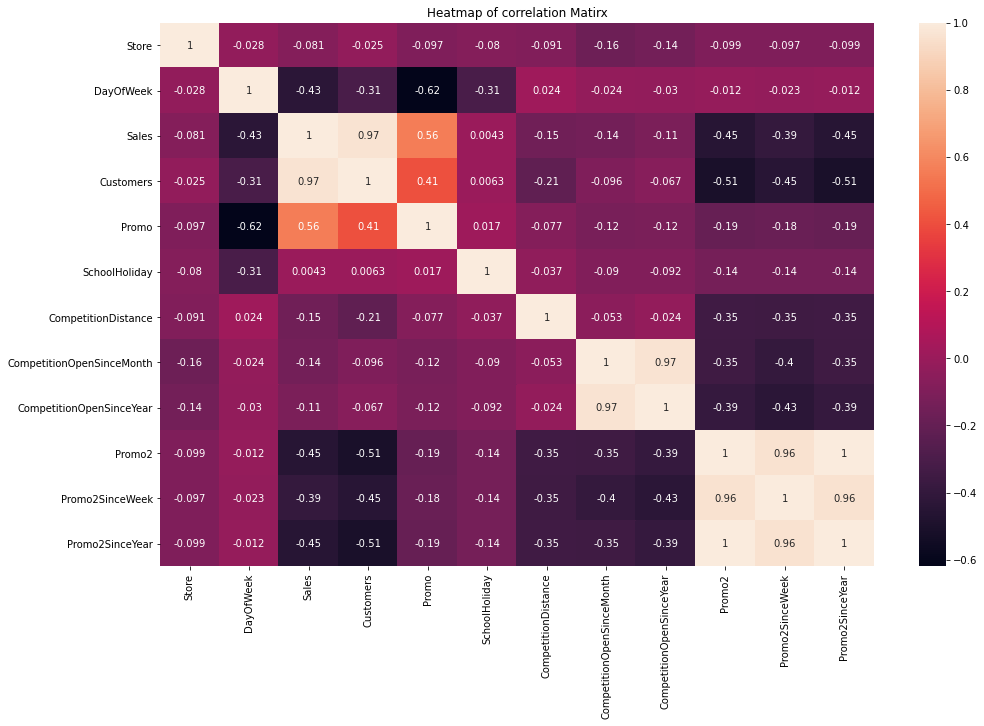

In [50]:
correlations = store_sales_merged.corr()

fig, ax = plt.subplots(figsize=(16,10)) 
corr = correlations.corr()
sns.heatmap(corr,
            annot=True,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)
plt.title('Heatmap of correlation Matirx')

corr

### Correlation in respect to the target variable sales

<AxesSubplot:title={'center':'correlation with sales'}>

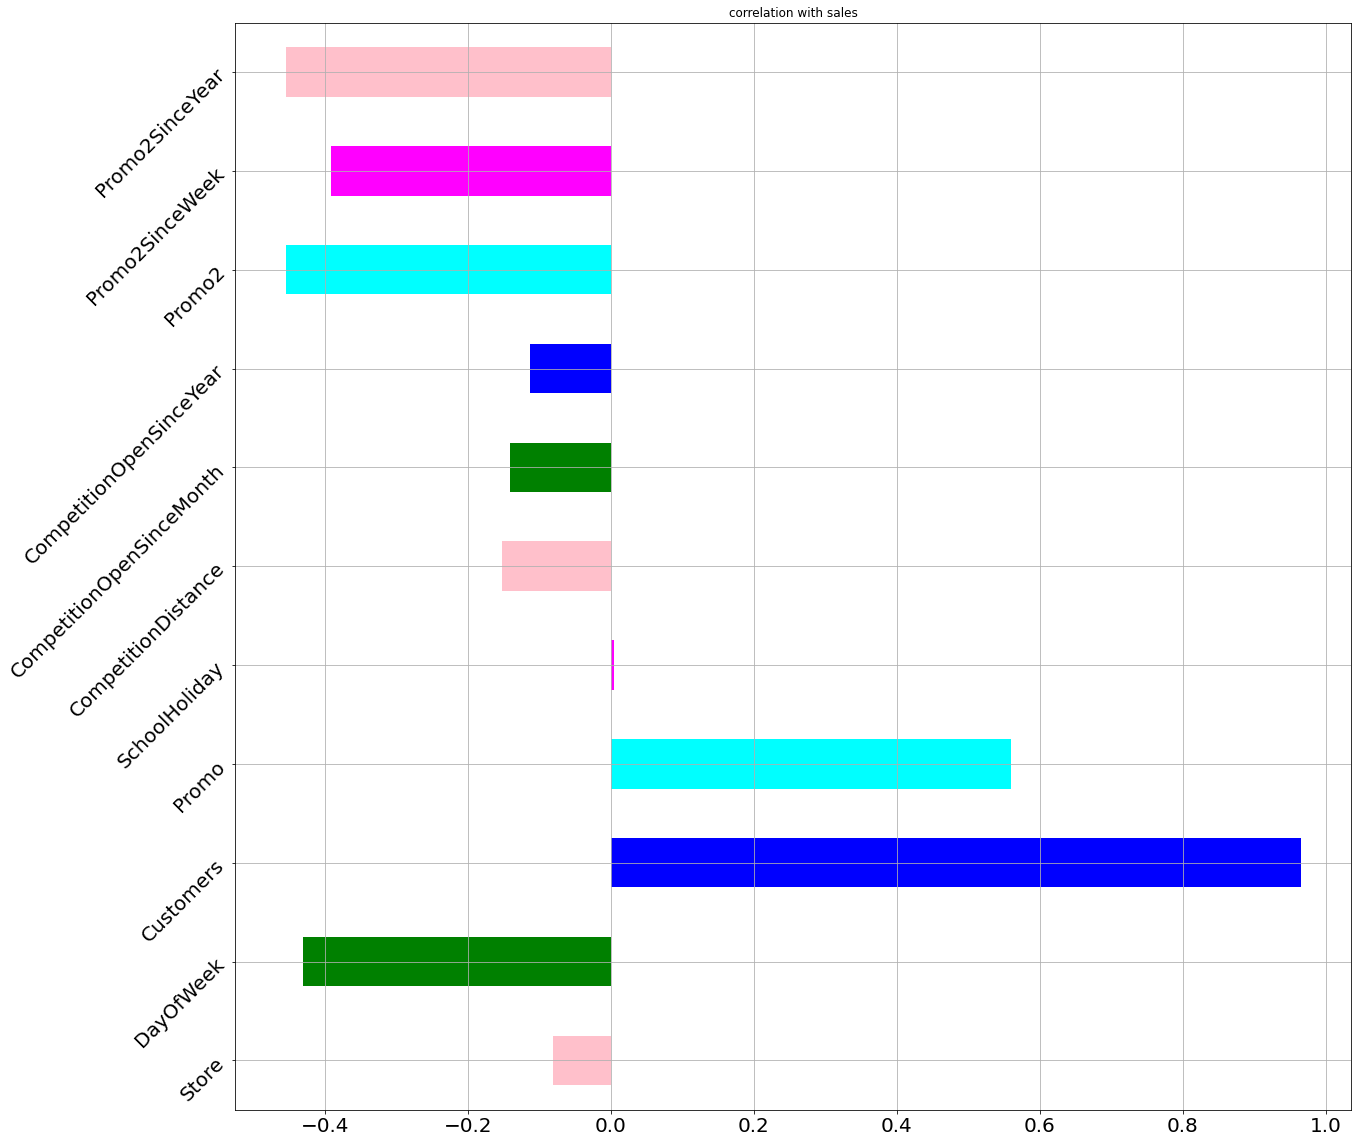

In [51]:
# Just a better correlation picture for visualization. 
# choose horizontal to align the column names better. 

#Dropping the unnecessary columns
correlations_dropped = correlations.drop(columns = ['Sales'])

#Correlation of independent variable with dependent variable

correlations_dropped.corrwith(correlations.Sales).plot.barh(figsize=(20,20), 
                                                    title="correlation with sales",
                                             fontsize=20,
                                                    rot=45,grid= True,color=['pink','green',
                                                                                  'blue','cyan','magenta'])

### Results 
- Customers have a very strong correlation with our target variable which makes complete sense. The more customers the more sales. 
- We notice a very high correlation between some independent variables such as customers and sales, 'Promo2',''Promo2SinceWeek', and ''Promo2SinceYear have either a .96 or a one to one relationship with eah other. 
***

<a id='Date'></a>
# Clean Date column

- Separate the year and put it into a separate column

***

In [52]:
store_sales_merged['Year'] = pd.DatetimeIndex(store_sales_merged['Date']).year

In [53]:
store_sales_merged['Month'] = pd.DatetimeIndex(store_sales_merged['Date']).month

In [54]:
store_sales_merged['Day'] = pd.DatetimeIndex(store_sales_merged['Date']).day

In [55]:
store_sales_merged

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,7
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,5
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,4
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,3


<a id='Visual'></a>
# Visualize sales 

***

Text(0.5, 1.0, 'Average Sales Per Month')

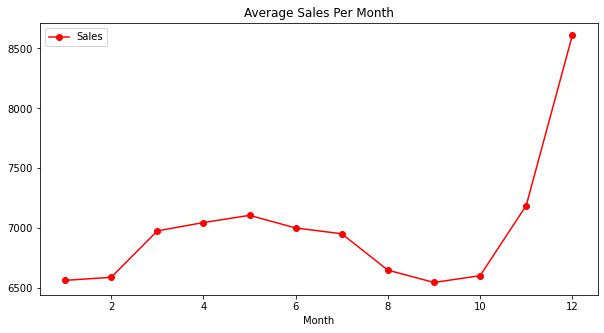

In [56]:
# Average sales and avearage number of customers per month 
# Groupy works great by grouping all the data that share the same month column, then obtain the mean of the sales column.

axis = store_sales_merged.groupby('Month')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Month')

Text(0.5, 1.0, 'Average Customers Per Month')

<Figure size 432x288 with 0 Axes>

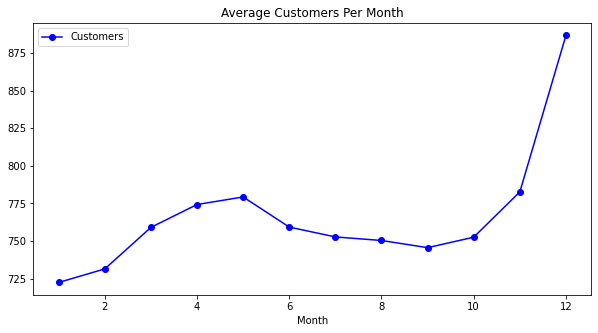

In [57]:
plt.figure()
axis = store_sales_merged.groupby('Month')[['Customers']].mean().plot(figsize = (10,5), marker = 'o', color = 'b')
axis.set_title('Average Customers Per Month')

Text(0.5, 1.0, 'Average Customers Per Day')

<Figure size 432x288 with 0 Axes>

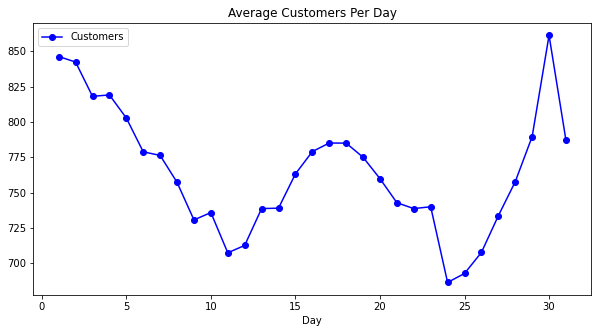

In [58]:
plt.figure()
axis = store_sales_merged.groupby('Day')[['Customers']].mean().plot(figsize = (10,5), marker = 'o', color = 'b')
axis.set_title('Average Customers Per Day')

Text(0.5, 1.0, 'Average Sales Per Day')

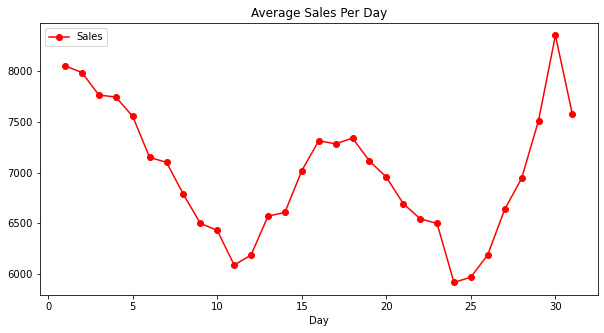

In [59]:
axis = store_sales_merged.groupby('Day')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Day')

Text(0.5, 1.0, 'Average Sales Per Day of the week')

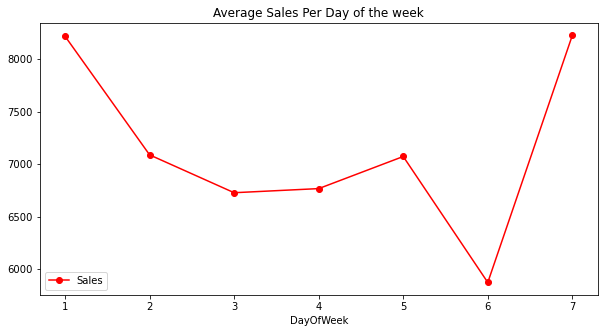

In [60]:
axis = store_sales_merged.groupby('DayOfWeek')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Average Sales Per Day of the week')

Text(0.5, 1.0, 'Average Customers Per Day of the week')

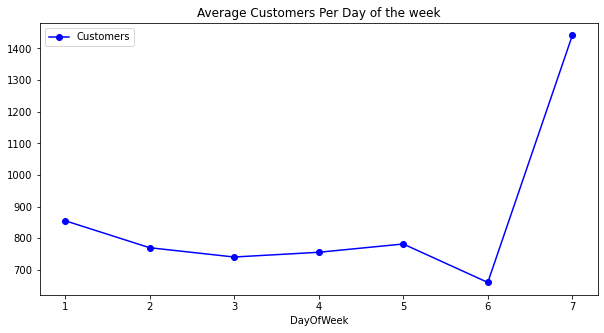

In [61]:
axis = store_sales_merged.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10,5), marker = 'o', color = 'b')
axis.set_title('Average Customers Per Day of the week')

### Results 

- Most of use probably would've aleady assumed that December would be the highest sales due to christmas shopping.
- Since customers and sales are correlated. It makes sense that the graph loooks the same when it comes to peak months. 
- Looks like the highest average amount of customers per day comes in the first two days of the month, decreases then jumps back up on the 30th. 
- Minumum amount of customers are generally around the 24th. 
- Sunday and Monday shows the highest average sales per day of the week. It is interesting to see that average customers per day of the week is much lower than Sunday. 


***

<a id='Store'></a>
# Visualize StoreType

***

<AxesSubplot:xlabel='Date'>

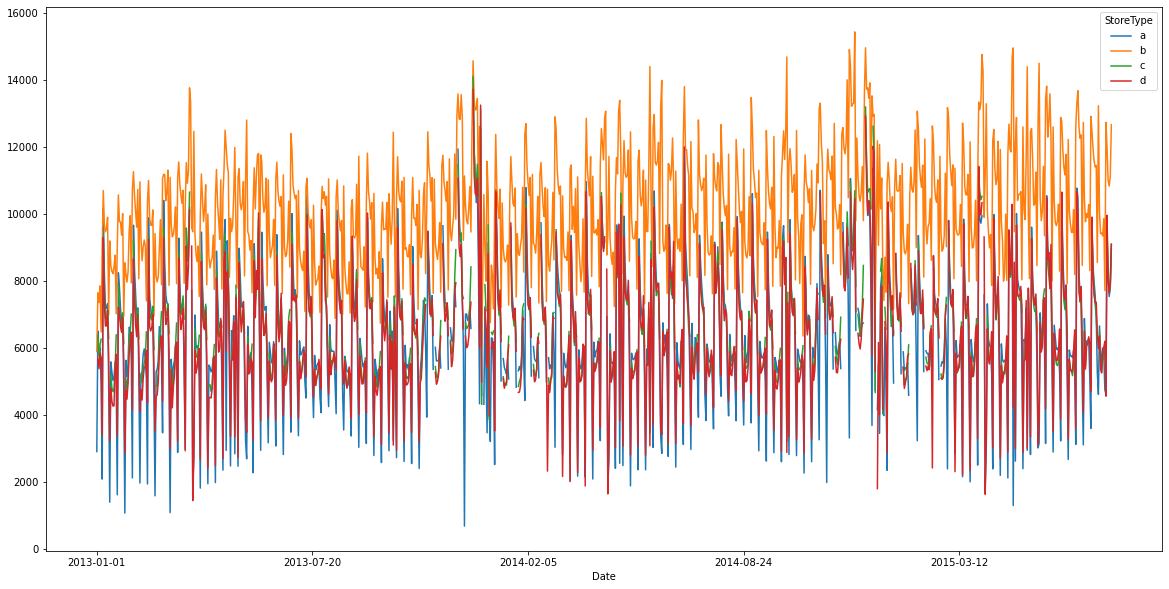

In [62]:
# which store type have the highest number of sales and highest amount of sales 

fig, ax = plt.subplots(figsize = (20, 10))

store_sales_merged.groupby(['Date', 'StoreType']).mean()['Sales'].unstack().plot(ax = ax)

### Results 

- StoreType b have the highest average sales and StoreType a have the least avearage sales.

*** 

<a id='Promo'></a>
# Visualize Promo

***

<AxesSubplot:xlabel='Promo', ylabel='Customers'>

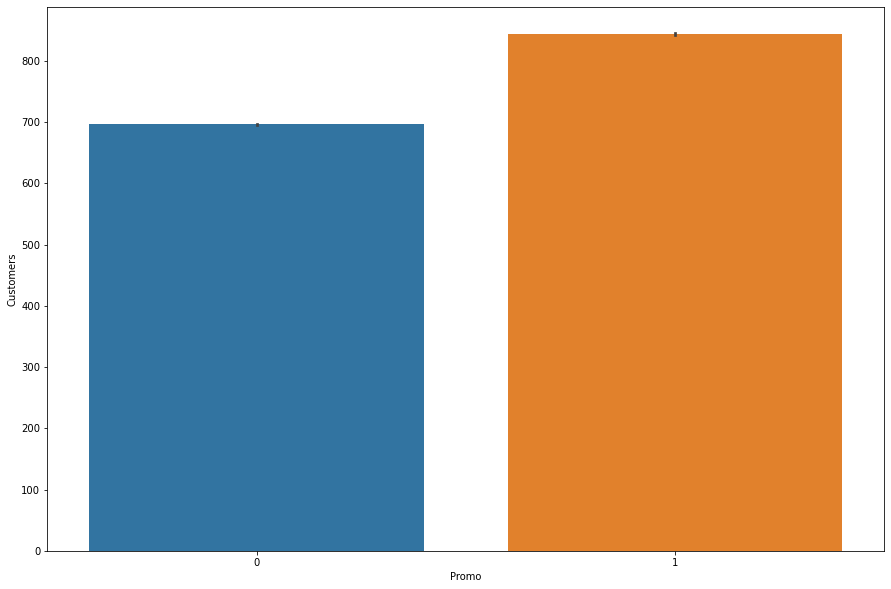

In [63]:
# promo customer to See if promo makes an effect on it or not
fig, ax = plt.subplots(figsize = (15, 10))
sns.barplot(x = 'Promo', y = 'Customers', data = store_sales_merged)

<AxesSubplot:xlabel='Promo', ylabel='Sales'>

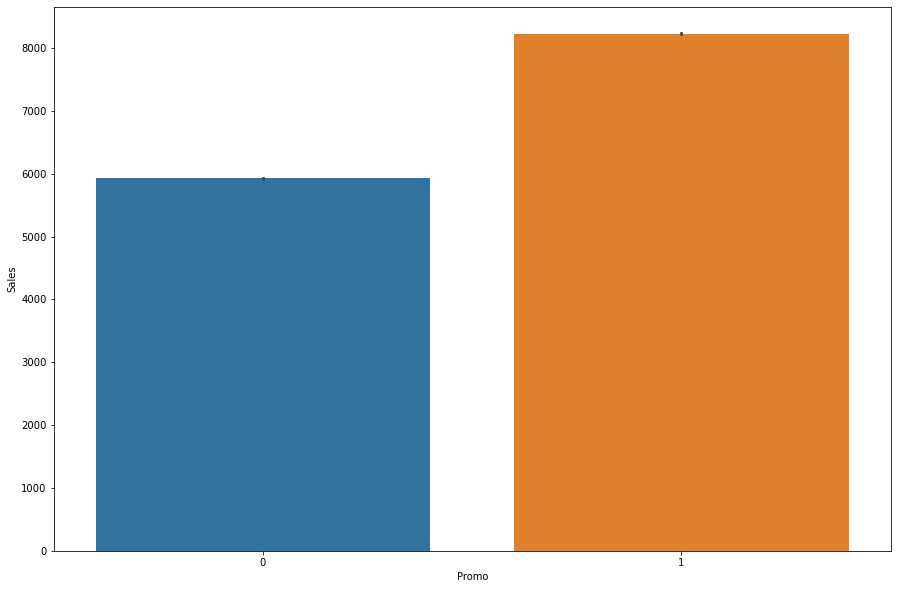

In [64]:
# promo sales to See if promo makes an effect on it or not

plt.figure(figsize = [15,10])

sns.barplot(x = 'Promo', y = 'Sales', data = store_sales_merged)

<AxesSubplot:xlabel='Promo', ylabel='Sales'>

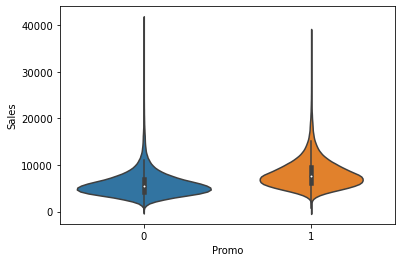

In [65]:
# Looking at the distribution between promo and Sales

sns.violinplot(x = 'Promo', y = 'Sales', data = store_sales_merged)

<AxesSubplot:xlabel='Promo', ylabel='Customers'>

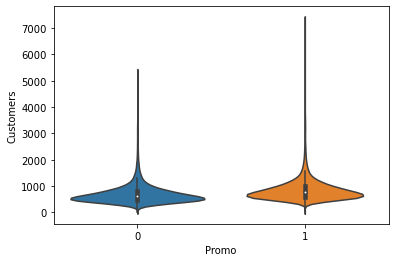

In [66]:
# Looking at the distribution between promo and Sales

sns.violinplot(x = 'Promo', y = 'Customers', data = store_sales_merged)

### Results 

- When stores are participating in promos the sales and customers increase. 
- Can see that when promo is running their is a higher average of customers and sales compared to when promo is not running. 
*** 

<a id='FB'></a>
# Model Building

***

# Facebook prophet: 

- If you give it historical data (more the better) about sales for example maybe 3 years in the past. With all the seasonalities, holidays etc in there. It can predict the future for you. 
- Can tell you what the expected sales are for maybe 2 months or whatever. 
- Can predict future sales future customers etc. 

In [79]:
# Have to rename the columns of the date and sales due to the guidelines of FB prophat.
# Run FB prohat to make future predictions on a specific store 
# Periods: how long I need predict in the future. 

def sales_predictions(Store_ID, store_info, periods):
    store_info = store_info[store_info['Store'] == Store_ID]            # Based on the store_ID i need to extract back that specific data related to that store 
    store_info = store_info[['Date', 'Sales']].rename(columns = {'Date':'ds', 'Sales':'y'})                    # Rename data and store columns 
    store_info = store_info.sort_values('ds')                          # Sort in ascending order (oldest to recent)
    model = Prophet()                                                       # instantiate the object 
    model.fit(store_info)
    future = model.make_future_dataframe(periods = periods)                # Create dataframe for the future. Specify how long for the predictions 
    forecast = model.predict(future)                                                 # Make forecast 
    figure = model.plot(forecast, xlabel = 'Date',ylabel = 'Sales')                   # Plot results 
    figure2 = model.plot_components(forecast)
    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


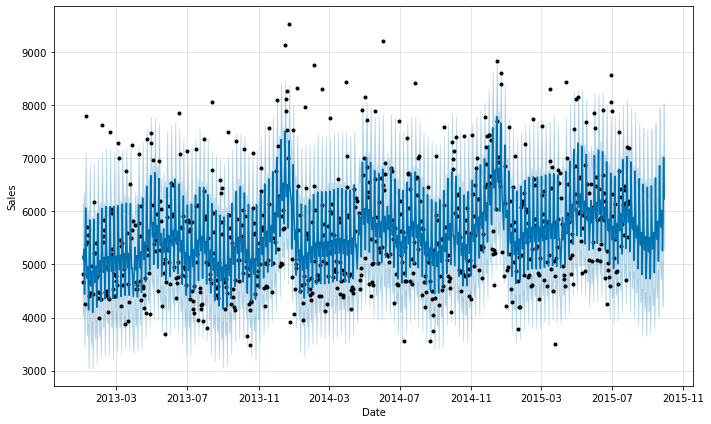

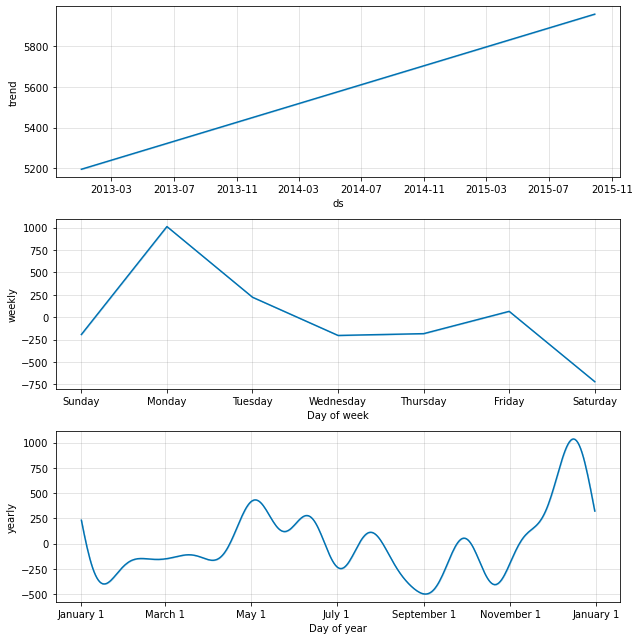

In [80]:
# Test 

store_ID10 = sales_predictions(10, store_sales_merged, 60)
store_ID10

# Resutls 
- Black dots are our historical data
- 1st graph: FB prophets tells us the future sales within every single day in the future and bounds (upper and lower): like the confidence (future predictions are at the end)
- 2nd graph: Trends for sales 
- 3rd graph: Trends for day of the week
- 4th graph: Trends for the month of year

# Train model for seasonality 
- StateHoliday - Indicates a state holiday, Normally all stores, with a few exceptions are closed. Schools are closed on public holidays and weekedns and weekend (a = public holiday, b = easter, c = christmas, 0 = none)
- SchoolHoliday: Indicates if the (store,Date) was affected by the closure of public schools 

In [81]:
# added holidays in the model 

def sales_predictions(Store_ID, store_info, holidays, periods):
    store_info = store_info[store_info['Store'] == Store_ID]            # Based on the store_ID i need to extract back that specific data related to that store 
    store_info = store_info[['Date', 'Sales']].rename(columns = {'Date':'ds', 'Sales':'y'})                    # Rename data and store columns 
    store_info = store_info.sort_values('ds')                          # Sort in ascending order (oldest to recent)
    model = Prophet(holidays = holidays)                                                       # instantiate the object 
    model.fit(store_info)
    future = model.make_future_dataframe(periods = periods)                # Create dataframe for the future. Specify how long for the predictions 
    forecast = model.predict(future)                                                 # Make forecast 
    figure = model.plot(forecast, xlabel = 'Date',ylabel = 'Sales')                   # Plot results 
    figure2 = model.plot_components(forecast)

In [82]:
# Get all the dates pertaining to school holidays 
# All values associated wit the date when the school holiday is 1

school_holidays = store_sales_merged[store_sales_merged['SchoolHoliday'] == 1].loc[:, 'Date'].values       
school_holidays

array(['2015-07-31', '2015-07-30', '2015-07-29', ..., '2013-01-04',
       '2013-01-03', '2013-01-02'], dtype=object)

In [83]:
school_holidays.shape

(163457,)

In [89]:
# Get all the dates pertaining to state holidays 
state_holidays = store_sales_merged[(store_sales_merged['StateHoliday'] == 'a')| (store_sales_merged['StateHoliday'] == 'b') | (store_sales_merged['StateHoliday'] == 'c')].loc[:, 'Date'].values 

In [91]:
state_holidays.shape

(910,)

In [92]:
# rename and create data frame for state holiday 

state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                              'holiday':'state_holiday'})

In [93]:
state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
905,2013-04-01,state_holiday
906,2013-08-15,state_holiday
907,2015-06-04,state_holiday
908,2014-06-19,state_holiday


In [94]:
# rename and create data frame for school holiday 

school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                              'holiday':'school_holiday'})
school_holidays

,ds,holiday
0,2015-07-31,school_holiday
1,2015-07-30,school_holiday
2,2015-07-29,school_holiday
3,2015-07-28,school_holiday
4,2015-07-27,school_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


In [95]:
# combine 

school_state_holidays = pd.concat((state_holidays, school_holidays))
school_state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


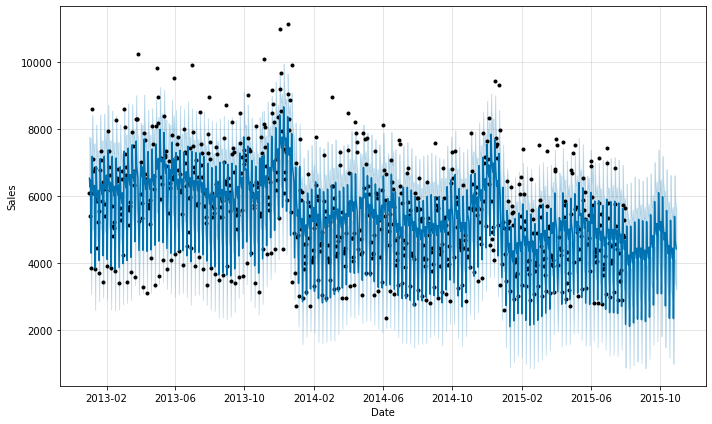

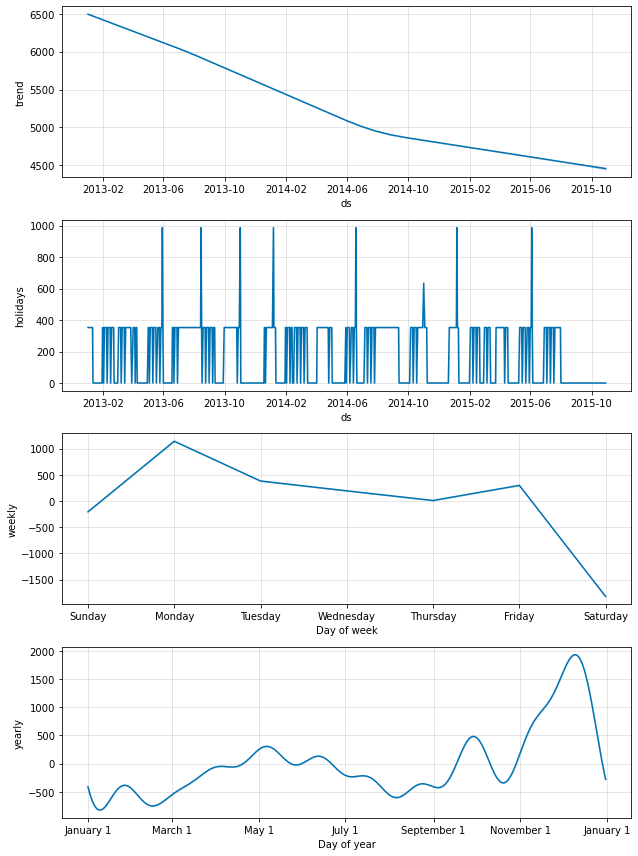

In [96]:
# Make predictions using holidays for specific store 
# Make predictiosn 90 days in future on store number 6

sales_predictions(6, store_sales_merged, school_state_holidays, 90)

### Results 

- 3rd graph: shows spikes on holidays 

In [67]:
store_info

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,0.0,0.0,0
1112,1113,a,c,9260.0,0.0,0.0,0,0.0,0.0,0
1113,1114,a,c,870.0,0.0,0.0,0,0.0,0.0,0


In [68]:
store_sales_merged

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,7
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,5
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,4
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,3


In [69]:
sales_transactions

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1
...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,0,a,1
1016827,733,2,2013-01-01,10765,2377,0,a,1
1016863,769,2,2013-01-01,5035,1248,0,a,1
1017042,948,2,2013-01-01,4491,1039,0,a,1


<a id='Con'></a>
# Conlusion and review

- Businesses being able to predict the best selling days or months can better prepare when it comes to supplies, employees needed, etc. 
- Can apply NN such as lstm, xgboost to make predictions 

***